In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii, fits
#from astropy.modeling import fitting, FittableModel, Fittable2DModel, Fittable1DModel, Parameter, custom_model
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
import lmfit
import pandas as pd
from ipywidgets import FloatProgress
from IPython.display import display
#import corner
from MUSE_Models import MUSE_3D_OIII, MUSE_3D_residual, PNextractor, PSF_residuals
%config InlineBackend.figure_format = 'retina'

In [4]:
data = ascii.read("M87_data/wavelength.txt", names=["wavelength"])
wavelength = np.array(data["wavelength"])

# Open Fits file and assign to tdata
hdulist = fits.open("M87_data/M87_rescube.fits")
Flux_data_flat = (hdulist[0].data)
# Reshape into a datacube 318x315x271
x_data = 315
y_data = 318
Flux_data = np.array(Flux_data_flat).reshape((y_data, x_data, len(wavelength)))

x_y_list = np.load("exported_data/M87/x_y_list.npy")
x_PNe = np.array([x[0] for x in x_y_list])
y_PNe = np.array([y[1] for y in x_y_list])

n_pixels= 13
c = 299792458.0

coordinates = [(n,m) for n in range(n_pixels) for m in range(n_pixels)]
x_fit = np.array([item[0] for item in coordinates])
y_fit = np.array([item[1] for item in coordinates])

# Retrieve the respective spectra for each PNe source

flatten = lambda l: [item for sublist in l for item in sublist]
std_MUSE = 1.16

PNe_spectra = np.array([PNextractor(x, y, n_pixels, Flux_data, wave=wavelength, dim=2.0) for x,y in zip(x_PNe, y_PNe)])

# create Pandas data frame for values
PNe_df = pd.DataFrame(columns=("PNe number", "Total Flux", "Flux error", "V (km/s)", "m 5007", "M 5007", "M 5007 error","A/rN"))
PNe_df["PNe number"] = np.arange(1,len(x_PNe)+1)
# .loc(Row, column name)

#construct error cube
error_cube = np.zeros((len(x_PNe), n_pixels**2, len(wavelength)))
for PNe_num in np.arange(0, len(x_PNe)):
    list_of_std = [np.abs(np.std(spec)) for spec in PNe_spectra[PNe_num]]
    error_cube[PNe_num] = [np.repeat(list_of_std[i], len(wavelength)) for i in np.arange(0, len(list_of_std))]

## Parameter Setup

In [24]:

PNe_params = Parameters()
PNe_params.add('Amp_2D', value=200., min=0.0)
PNe_params.add('x_0', value=n_pixels/2., min=0., max=n_pixels)
PNe_params.add('y_0', value=n_pixels/2., min=0., max=n_pixels)
PNe_params.add("M_FWHM", value=6.89, min=0.001, max=15., vary=False)
PNe_params.add("beta", value=1.56, min=0.01, max=20., vary=False) 
PNe_params.add("mean", value=5007., min=4970, max=5040)
PNe_params.add("Gauss_FWHM", value=1.16, vary=False) # LSF, instrumental resolution.
PNe_params.add("Gauss_bkg",  value=0.00001)
PNe_params.add("Gauss_grad", value=0.00001)

#FWHM:  6.88827603298 4.26221737712
#Beta:  1.0885229982 0.527905820424


## Fitting routine

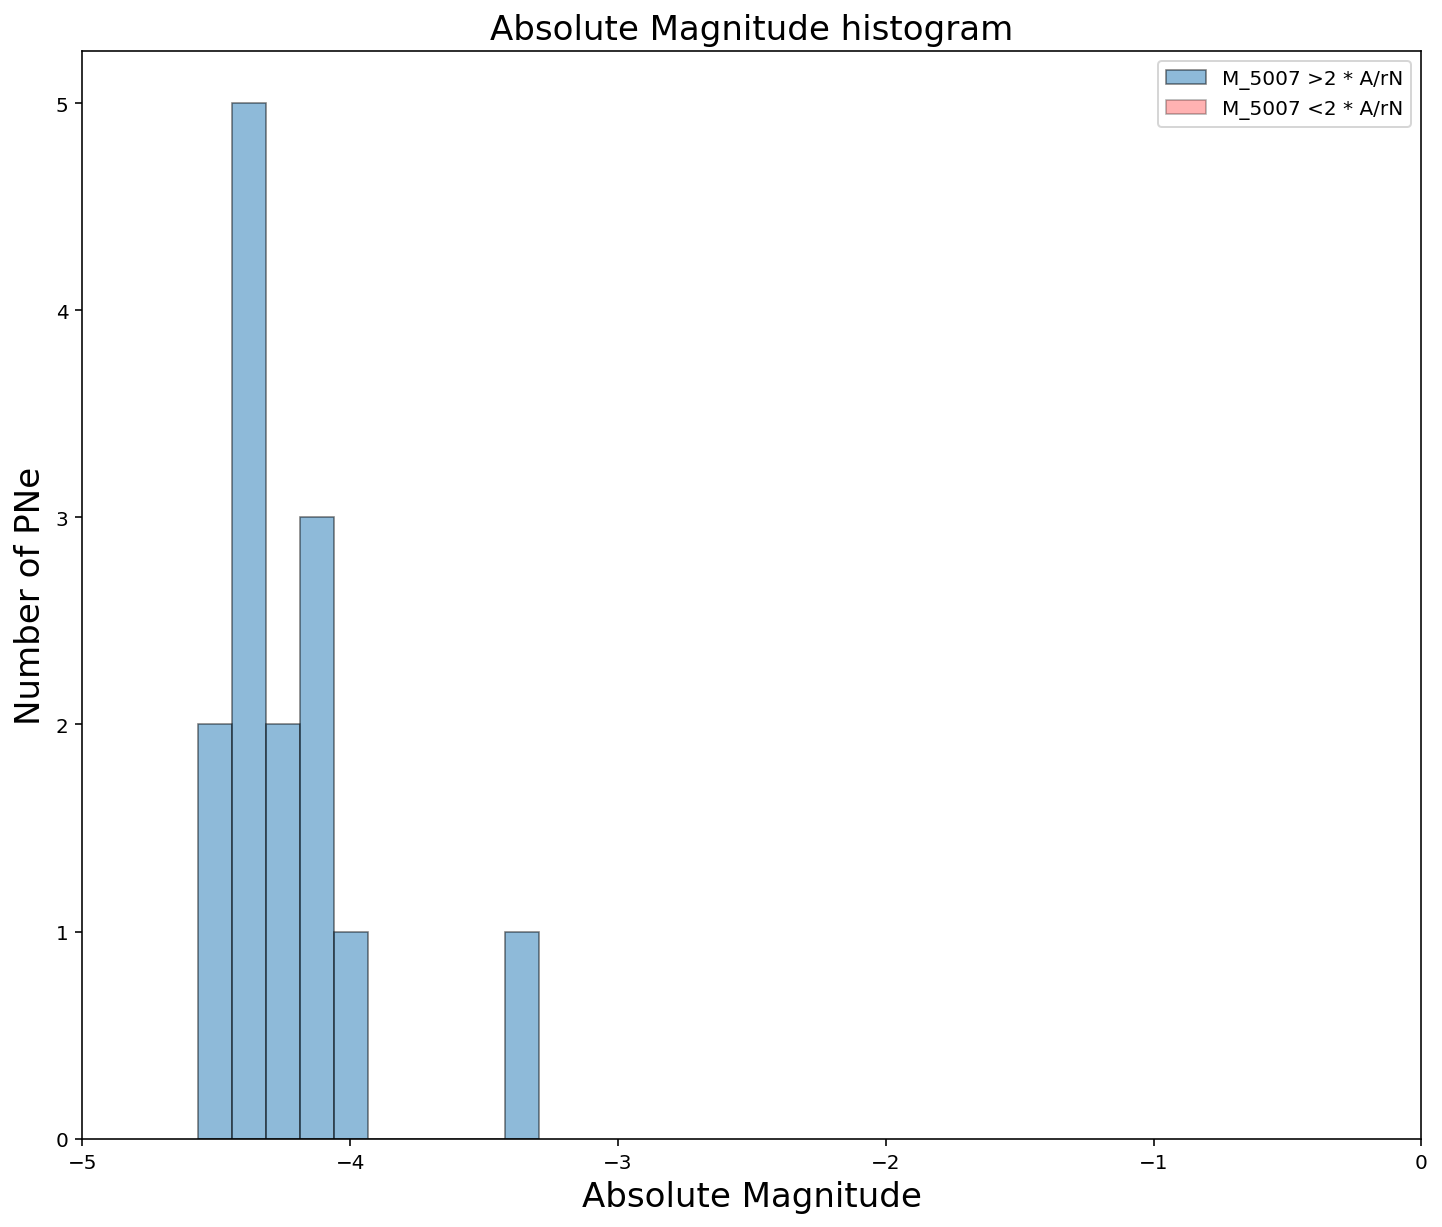

In [28]:
# useful value storage setup
total_Flux = np.zeros(len(x_PNe))
residuals_list = np.zeros(len(x_PNe))
A_OIII_list = np.zeros(len(x_PNe))
F_OIII_xy_list = np.zeros((len(x_PNe), len(PNe_spectra[0])))
M_amp_list = np.zeros(len(x_PNe))
mean_wave_list = np.zeros(len(x_PNe))
list_of_fit_residuals = np.zeros((len(x_PNe), n_pixels*n_pixels, len(wavelength)))

# error lists
moff_A_err = np.zeros(len(x_PNe))
x_0_err = np.zeros(len(x_PNe))
y_0_err = np.zeros(len(x_PNe))
mean_wave_err = np.zeros(len(x_PNe))
Gauss_bkg_err = np.zeros(len(x_PNe))
Gauss_grad_err = np.zeros(len(x_PNe))

FWHM_list = np.zeros(len(x_PNe))
list_of_x = np.zeros(len(x_PNe))
list_of_y = np.zeros(len(x_PNe))
Gauss_bkg = np.zeros(len(x_PNe))
Gauss_grad = np.zeros(len(x_PNe))

model_2D = "Moffat"
#model_2D = "Gauss"
#model_2D = "Gauss_2"

for PNe_num in np.arange(0, len(x_PNe)):
    useful_stuff = []
    #run minimizer fitting routine
    fit_results = minimize(MUSE_3D_residual, PNe_params, args=(wavelength, x_fit, y_fit, PNe_spectra[PNe_num], error_cube[PNe_num], model_2D, PNe_num, useful_stuff), nan_policy="propagate")
    # Store values in numpy arrays
    if model_2D == "Moffat" or model_2D == "Gauss":
        PNe_df.loc[PNe_num, "Total Flux"] = np.sum(useful_stuff[1][1]) * 1e-20
    if model_2D == "Gauss_2":
        PNe_df.loc[PNe_num, "Total Flux"] = (np.sum(useful_stuff[1][2]) + (0.68 * np.sum(useful_stuff[1][3]))) * 1e-20
    list_of_fit_residuals[PNe_num] = useful_stuff[0]
    A_OIII_list[PNe_num] = useful_stuff[1][0]
    F_OIII_xy_list[PNe_num] = useful_stuff[1][1]
    M_amp_list[PNe_num] = fit_results.params["Amp_2D"]
    list_of_x[PNe_num] = fit_results.params["x_0"]
    list_of_y[PNe_num] = fit_results.params["y_0"]
    mean_wave_list[PNe_num] = fit_results.params["mean"]
    Gauss_bkg[PNe_num] = fit_results.params["Gauss_bkg"]
    Gauss_grad[PNe_num] = fit_results.params["Gauss_grad"]
    #save errors
    moff_A_err[PNe_num] = fit_results.params["Amp_2D"].stderr
    x_0_err[PNe_num] = fit_results.params["x_0"].stderr
    y_0_err[PNe_num] = fit_results.params["y_0"].stderr
    mean_wave_err[PNe_num] = fit_results.params["mean"].stderr
    Gauss_bkg_err[PNe_num] = fit_results.params["Gauss_bkg"].stderr
    Gauss_grad_err[PNe_num] = fit_results.params["Gauss_grad"].stderr

# Signal to noise and Magnitude calculations
A_by_rN = A_OIII_list / residuals_list
PNe_df["A/rN"] = A_by_rN

def log_10(x):
    return np.log10(x)

PNe_df["m 5007"] = -2.5 * PNe_df["Total Flux"].apply(log_10) - 13.74
dM = 5. * np.log10(16.52) + 25
PNe_df["M 5007"] = PNe_df["m 5007"] - dM

plt.figure(1, figsize=(12,10))
info = plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>=2], bins=10, edgecolor="black", linewidth=0.8, label="M_5007 >2 * A/rN", alpha=0.5)
plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], edgecolor="black", linewidth=0.8, color="red", alpha=0.3, label="M_5007 <2 * A/rN")
plt.xlim(-5,0)
plt.title("Absolute Magnitude histogram", fontsize=17 )
plt.xlabel("Absolute Magnitude", fontsize=17)
plt.ylabel("Number of PNe", fontsize=17)
plt.legend()

bins_cens = info[1][:-1]
#plt.savefig("Plots/M87/M5007 histogram.png")

In [29]:
PNe_df

PNe number   Total Flux Flux error V (km/s)     m 5007    M 5007  \
0            1  7.85719e-17        NaN      NaN  26.521832 -4.568218   
1            2  6.06659e-17        NaN      NaN  26.802638 -4.287412   
2            3  6.89898e-17        NaN      NaN  26.663037 -4.427013   
3            4  6.60199e-17        NaN      NaN  26.710814 -4.379237   
4            5  7.52112e-17        NaN      NaN  26.569293 -4.520757   
5            6  6.64622e-17        NaN      NaN  26.703563 -4.386488   
6            7  5.97495e-17        NaN      NaN  26.819164 -4.270886   
7            8  6.24497e-17        NaN      NaN  26.771175 -4.318876   
8            9  2.43397e-17        NaN      NaN  27.794214 -3.295836   
9           10  5.20621e-17        NaN      NaN  26.968695 -4.121355   
10          11   5.5124e-17        NaN      NaN  26.906647 -4.183403   
11          12  5.09135e-17        NaN      NaN  26.992917 -4.097133   
12          13  4.47666e-17        NaN      NaN  27.132616 -3.957434   
13          14  6.90502e-17        NaN      NaN  26.662087 -4.427963   

   M 5007 error  A/rN  
0           NaN   inf  
1           NaN   inf  
2           NaN   inf  
3           NaN   inf  
4           NaN   inf  
5           NaN   inf  
6           NaN   inf  
7           NaN   inf  
8           NaN   inf  
9           NaN   inf  
10          NaN   inf  
11          NaN   inf  
12          NaN   inf  
13          NaN   inf

# Completeness

C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\tspri\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


10342
16290
25006
37009


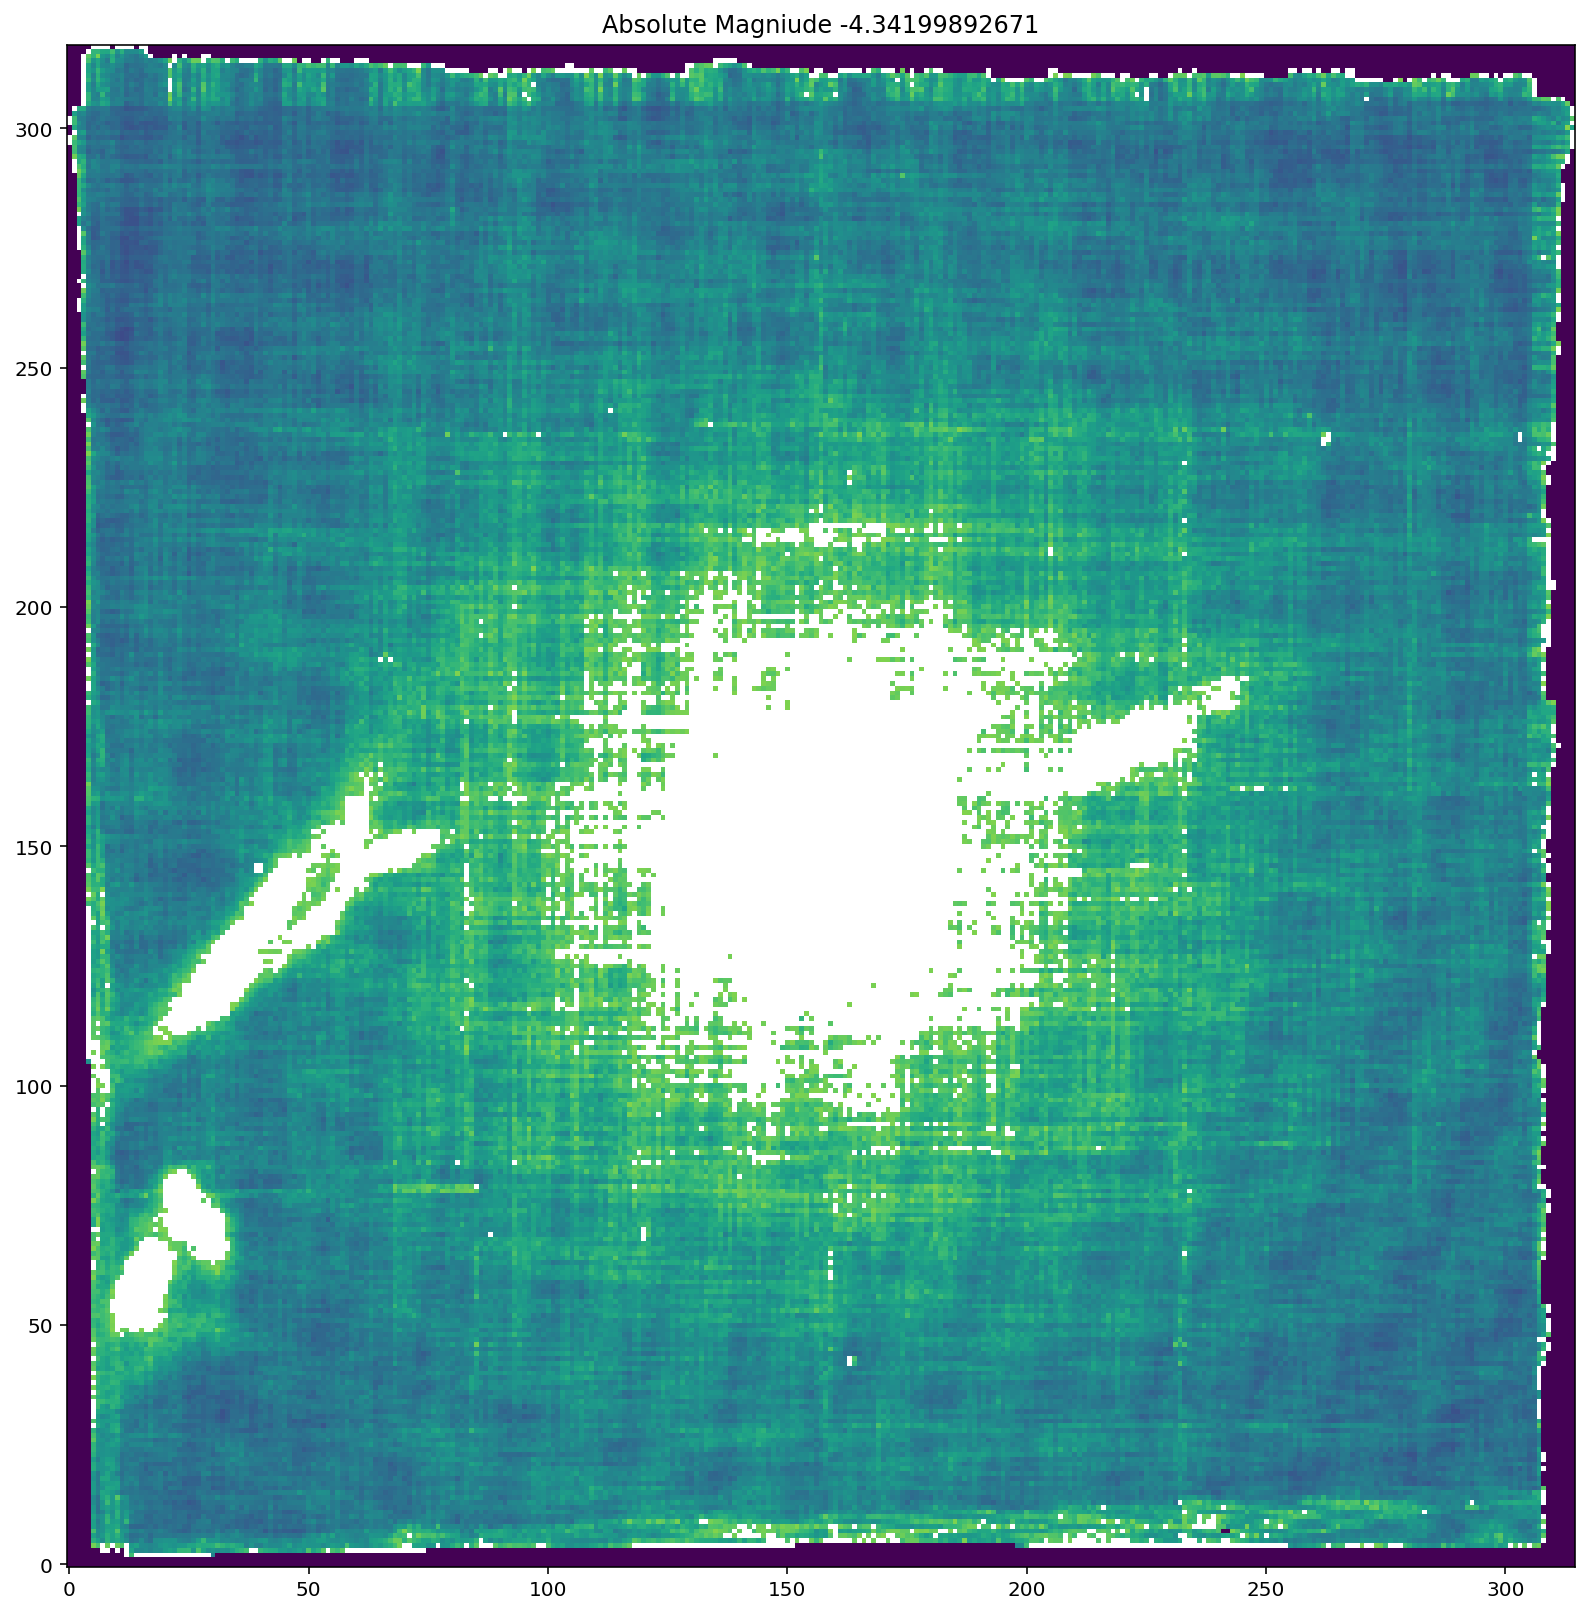

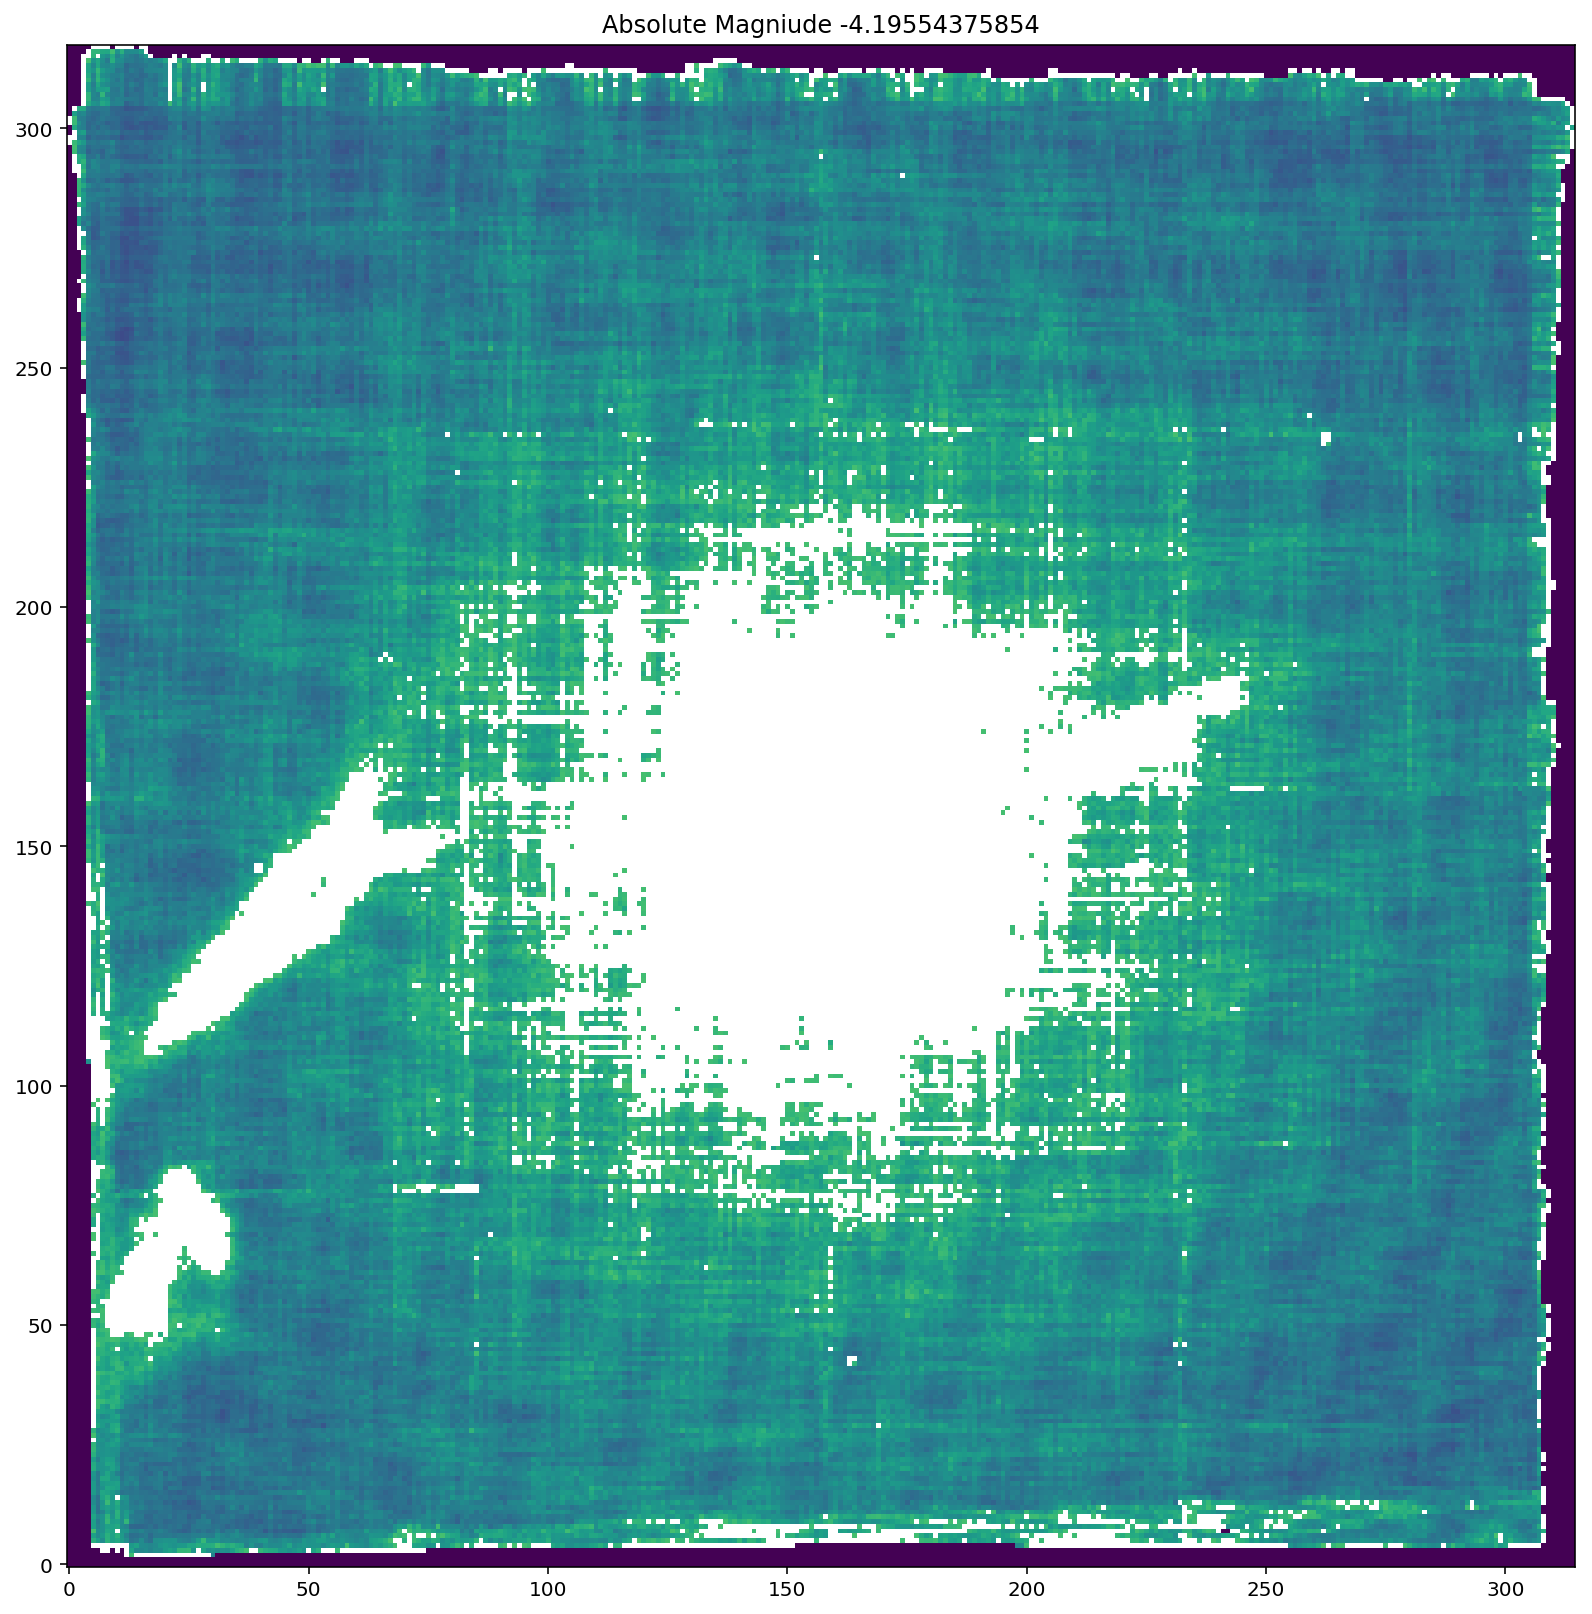

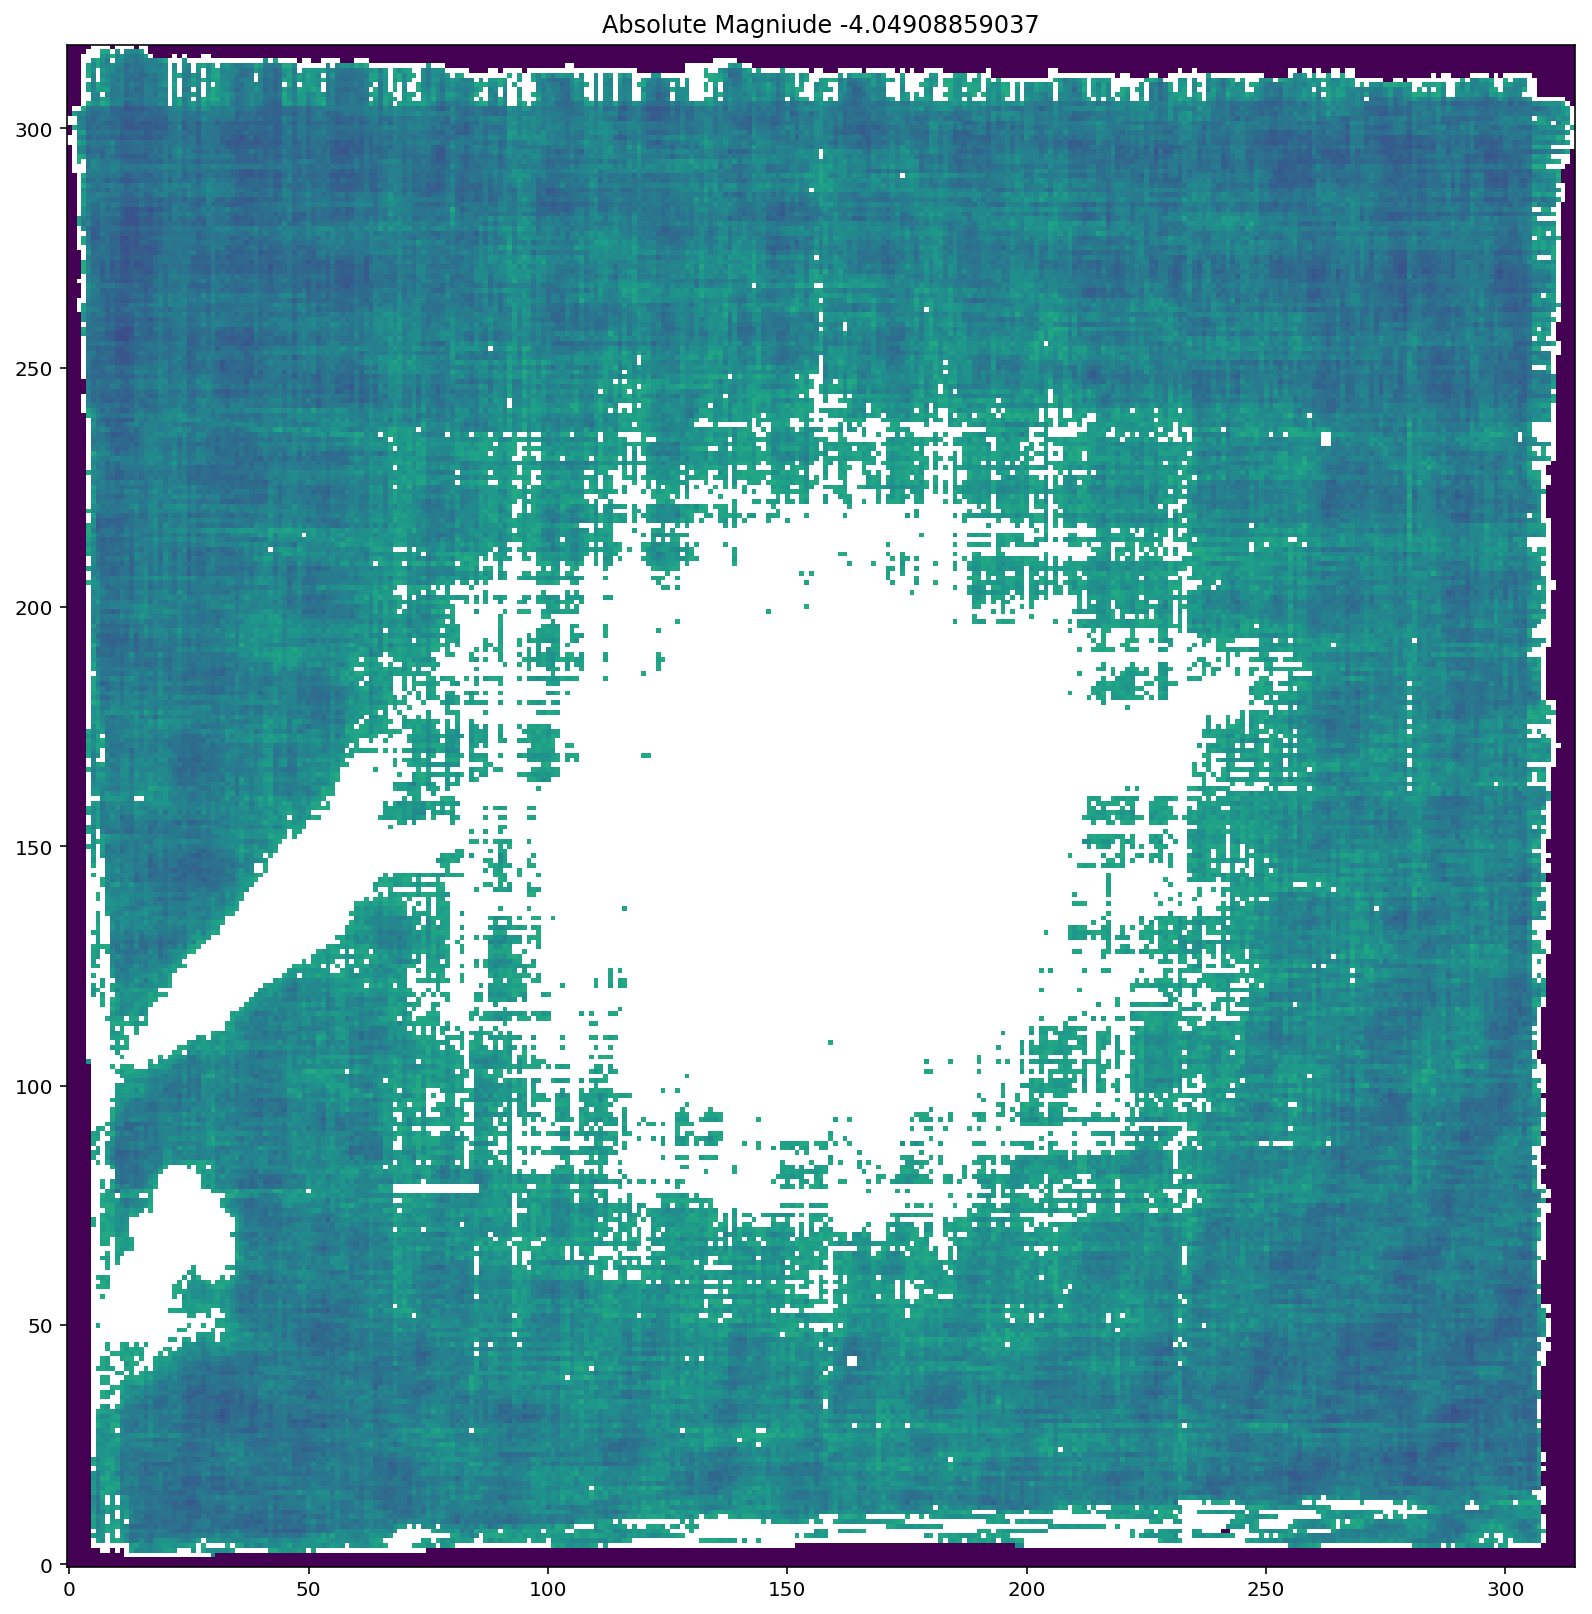

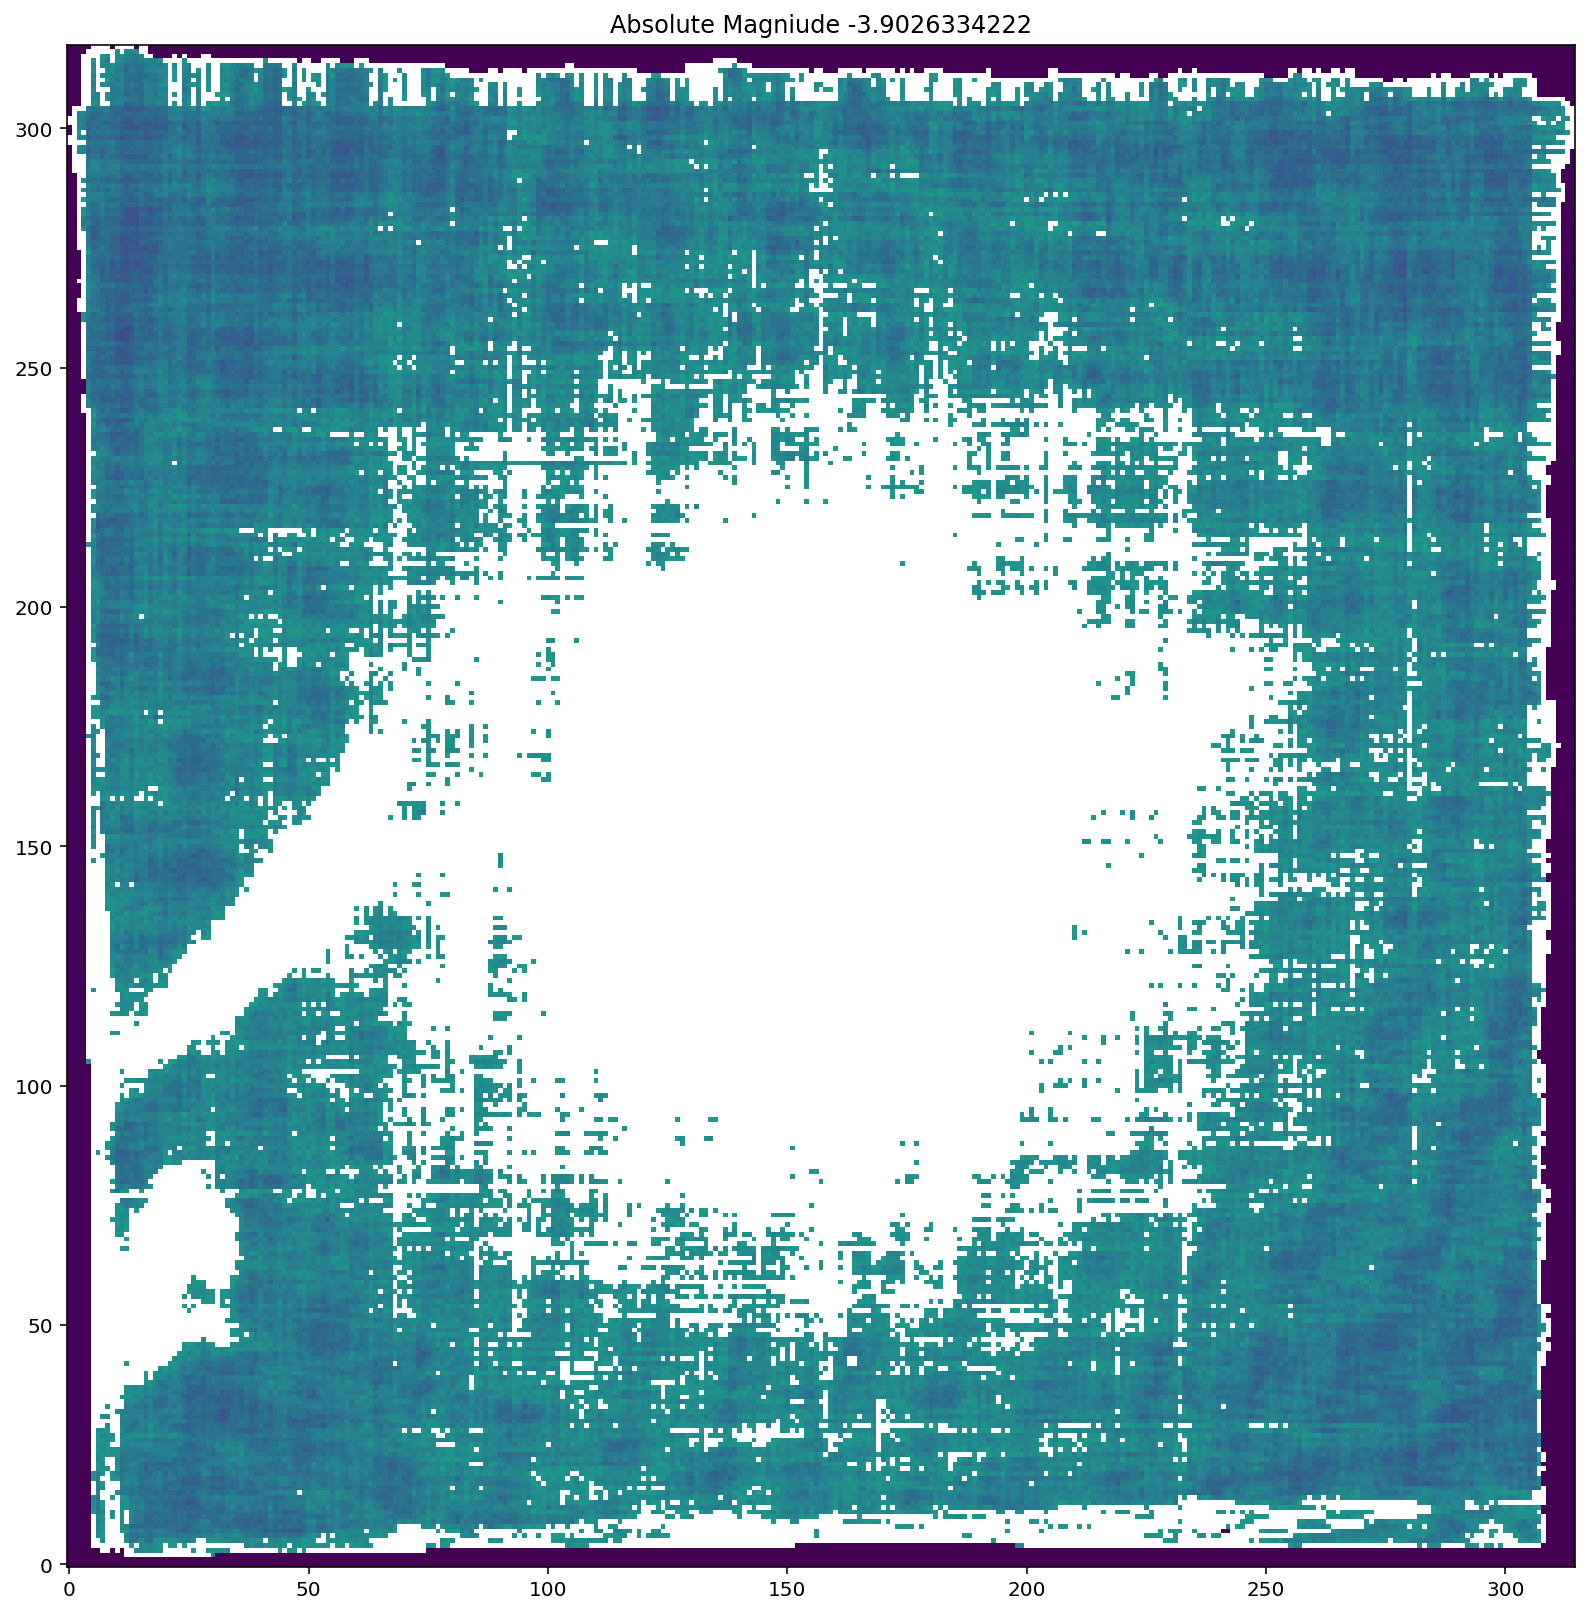

In [7]:
Noise_map = np.abs(np.std(Flux_data, axis=2))
Y,X = np.mgrid[:y_data,:x_data]
#plt.imshow(Noise_map, origin="lower", cmap="CMRmap", vmin=0, vmax=20)

# Setup range of Absolute Magnitudes to be converted to 1D max A values
Abs_M = bins_cens#np.arange(-4.5,-1.5, 0.3)#bins_cens
dM = 5. * np.log10(16.52)+25
app_m = Abs_M + dM

total_flux = 10**((app_m + 13.74) / -2.5)
flux = total_flux / 1e-20

def moffat(amplitude, x_0, y_0, FWHM, beta):
    gamma = FWHM / (2. * np.sqrt(2.**(1./beta) - 1.))
    rr_gg = ((x_fit - x_0)**2 + (y_fit - y_0)**2) / gamma**2
    return amplitude * (1 + rr_gg)**(-beta)

def gaussian(x, amplitude, mean, stddev, bkg, grad):
    return (bkg + grad*x + np.abs(amplitude) * np.exp(- 0.5 * (x - mean)** 2 / (stddev**2.)) +
                 (np.abs(amplitude)/3.) * np.exp(- 0.5 * (x - (mean - 47.9399))** 2 / (stddev**2.)))

init_FWHM = PNe_params["FWHM"].value
init_beta = PNe_params["beta"].value
sum_init = np.sum(moffat(1, n_pixels/2, n_pixels/2, init_FWHM, init_beta))
input_moff_A = flux / sum_init

# Make moffat models = F_5007 (x,y)
Moffat_models = np.array([moffat(moff_A, n_pixels/2., n_pixels/2., init_FWHM, init_beta) for moff_A in input_moff_A])

# A_5007 (x,y)
Amp_x_y = ((Moffat_models) / (np.sqrt(2*np.pi) * 1.19))

max_1D_A = np.array([np.max(A) for A in Amp_x_y])

N_data = len(np.nonzero(Noise_map)[0])

Noise_mask = Noise_map
Noise_mask_plot = []
ratio_counter = np.zeros(len(Abs_M))
for i,a in enumerate(max_1D_A):
    Noise_mask[((a / Noise_map) <2.0)] = np.nan
    nan_counter = np.isnan(Noise_mask).sum()
    print(nan_counter)
    ratio_counter[i] = (N_data-nan_counter) / N_data
    Noise_mask_plot.append(Noise_mask)
    plt.figure(figsize=(14,14))
    plt.title("Absolute Magniude %s" %Abs_M[i])
    plt.imshow(Noise_mask, origin="lower", vmin=0, vmax=20)
    #cb=plt.colorbar()
    #plt.savefig("Plots/FCC167/completeness/Abs M %s.png" %Abs_M[i])

#Noise_mask = Noise_map
#Noise_mask_plot = []
#
#fig, axs = plt.subplots(2,3, figsize=(20, 10))
#axs = axs.ravel()
#for i,a in enumerate(max_1D_A):
#    Noise_mask[((a / Noise_map) <2.0)] = np.nan
#    axs[i].set_title("$M_{5007} = $ %s" %Abs_M[i])
#    ax = axs[i].imshow(Noise_mask, origin="lower", vmin=0, vmax=30)
#
#plt.savefig("Plots/FCC167/completeness/stack.png")



# PNLF

In [8]:
PNLF_df = pd.DataFrame(columns=("M 5007", "PNLF", "binned_values"))
PNLF_df["M 5007"] = PNe_df["M 5007"].loc[PNe_df["A/rN"]>2.0]

diff = abs(bins_cens[0]-bins_cens[1]) / 2
bins_cens_left = bins_cens - diff
bins_cens_right = bins_cens + diff

PNLF_df["binned_values"] = np.digitize(PNLF_df["M 5007"], bins=bins_cens)

def PNLF_func(params, data):
    a = params["a"]
    
    # PNLF equation
    PNLF = (np.exp(0.307*PNe_df["M 5007"])) * (1-np.exp(3*((PNe_df["M 5007"].min() - PNe_df["M 5007"]))))
    PNLF_df["PNLF"] = PNLF
    # Binning of PNLF values
    PNLF_sum_list = np.zeros(len(bins_cens))
    for i in np.arange(1,len(bins_cens)+1):
        PNLF_sum_list[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    # Scale the binned values
    PNLF_scale = PNLF_sum_list * a 

    return data - PNLF_scale
                
params_PNLF = Parameters()
params_PNLF.add('a', value=5., min=0, max=100)

results = minimize(PNLF_func, params_PNLF, args=(info[0],), nan_policy="propagate")
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2], edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.5)
report_fit(results)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 9
    # data points      = 4
    # variables        = 1
    chi-square         = 16.2736261
    reduced chi-square = 5.42454204
    Akaike info crit   = 7.61300563
    Bayesian info crit = 6.99929999
[[Variables]]
    a:  16.3161826 +/- 6.64266537 (40.71%) (init = 5)


[ 0.21057784  2.1201557   3.3783044   4.09561108]


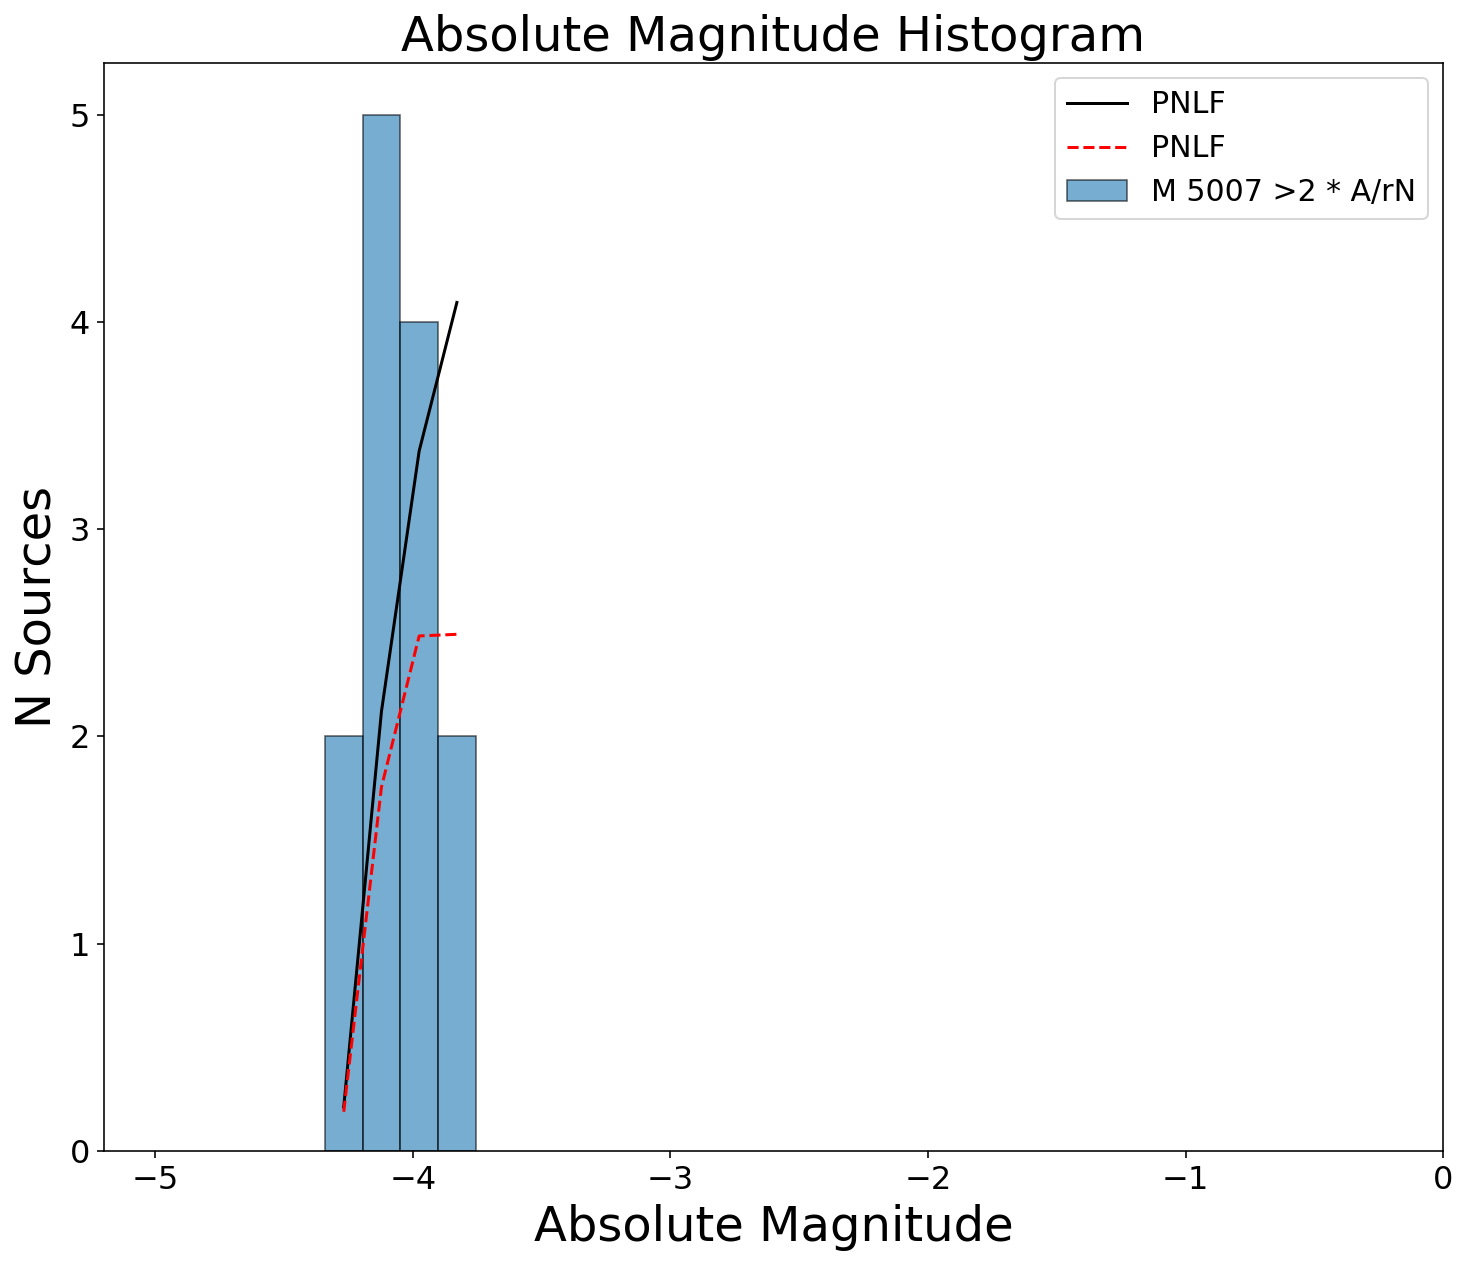

In [11]:
plt.figure(2, figsize=(12,10))
info = plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2],bins=4, edgecolor="black", linewidth=0.8, label="M 5007 >2 * A/rN", alpha=0.6)
#plt.hist(PNe_df["M 5007"].loc[PNe_df["A/rN"]<2], bins=4, edgecolor="black",linewidth=0.8, color="red", alpha=0.5, label="M 5007 <2 * A/rN")
ax = plt.gca()
plt.xlim(-5.2,0)
#plt.yticks(np.arange(0,22,2), np.arange(0,22,2))
plt.title("Absolute Magnitude Histogram", fontsize=24)
plt.xlabel("Absolute Magnitude", fontsize=24)
plt.ylabel("N Sources", fontsize=24)
ax.get_yticklabels()
ax.tick_params(labelsize=18)
ax.tick_params(labelsize=16)

PNLF = (np.exp(0.307*PNe_df["M 5007"])) * (1-np.exp(3*((PNe_df["M 5007"].min() - PNe_df["M 5007"]))))
PNLF = (PNLF * results.params["a"]) 
#plt.scatter(PNe_df["M 5007"].loc[PNe_df["M 5007"]>-5], PNLF, c="k")


binned_PNLF = np.zeros(len(bins_cens))
for i in np.arange(1,len(bins_cens)+1):
    binned_PNLF[i-1] = np.mean(PNLF_df["PNLF"].loc[PNLF_df["binned_values"]==i])
    
print(binned_PNLF*results.params["a"])
plt.plot(bins_cens_right, (binned_PNLF*results.params["a"]), color="k", label="PNLF" )
plt.plot(bins_cens_right, (binned_PNLF*results.params["a"])* ratio_counter, color="r", ls="--", label="PNLF" )
plt.legend(fontsize=15)
plt.savefig("Plots/M87/PNLF.png")

(-5, 1)

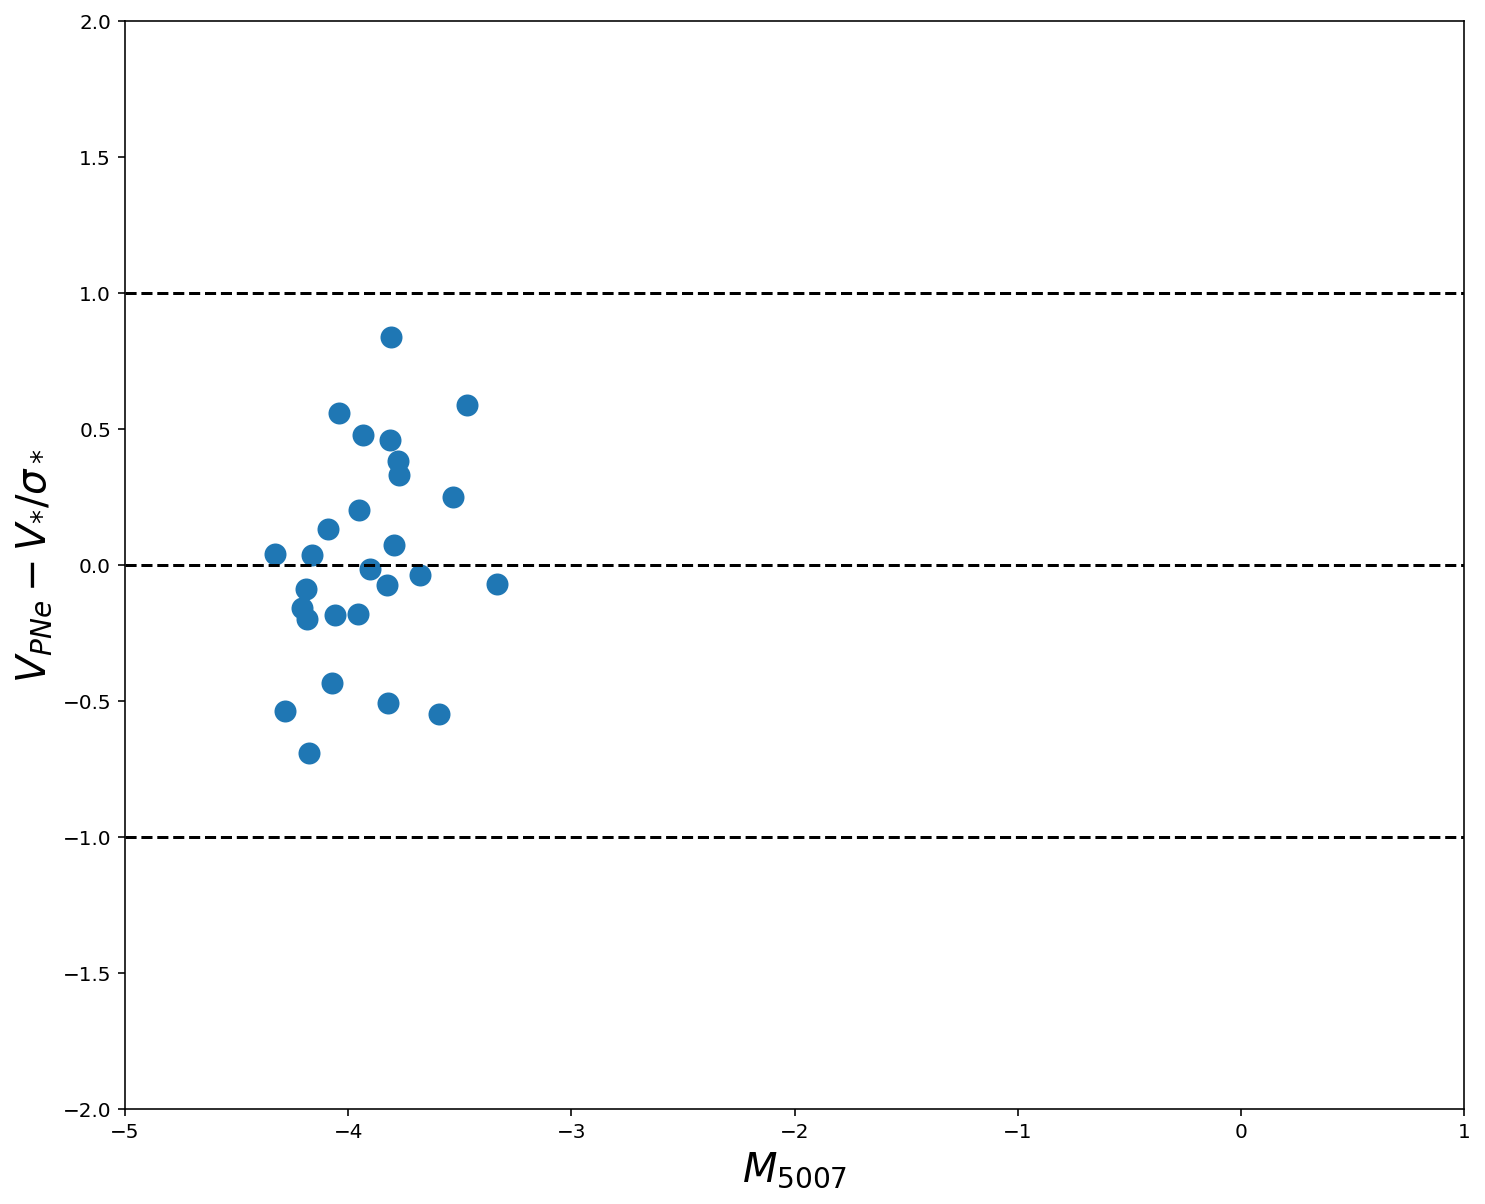

In [12]:
#%% Work on stellar dispersion comparison plot
stellar_vel = 0. # km/s
stellar_dis = 360. # km/s
PNe_vel_ratio = (PNe_df["V (km/s)"].loc[PNe_df["A/rN"]>2.] - stellar_vel)/ stellar_dis

plt.figure(44, figsize=(12,10))
plt.clf()
plt.scatter(PNe_df["M 5007"].loc[PNe_df["A/rN"]>2.], PNe_vel_ratio, s=100)
plt.xlabel("$M_{5007}$", fontsize=20)
plt.ylabel("$V_{PNe} - V_{*} / \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)
plt.xlim(-5,1)

(-2, 2)

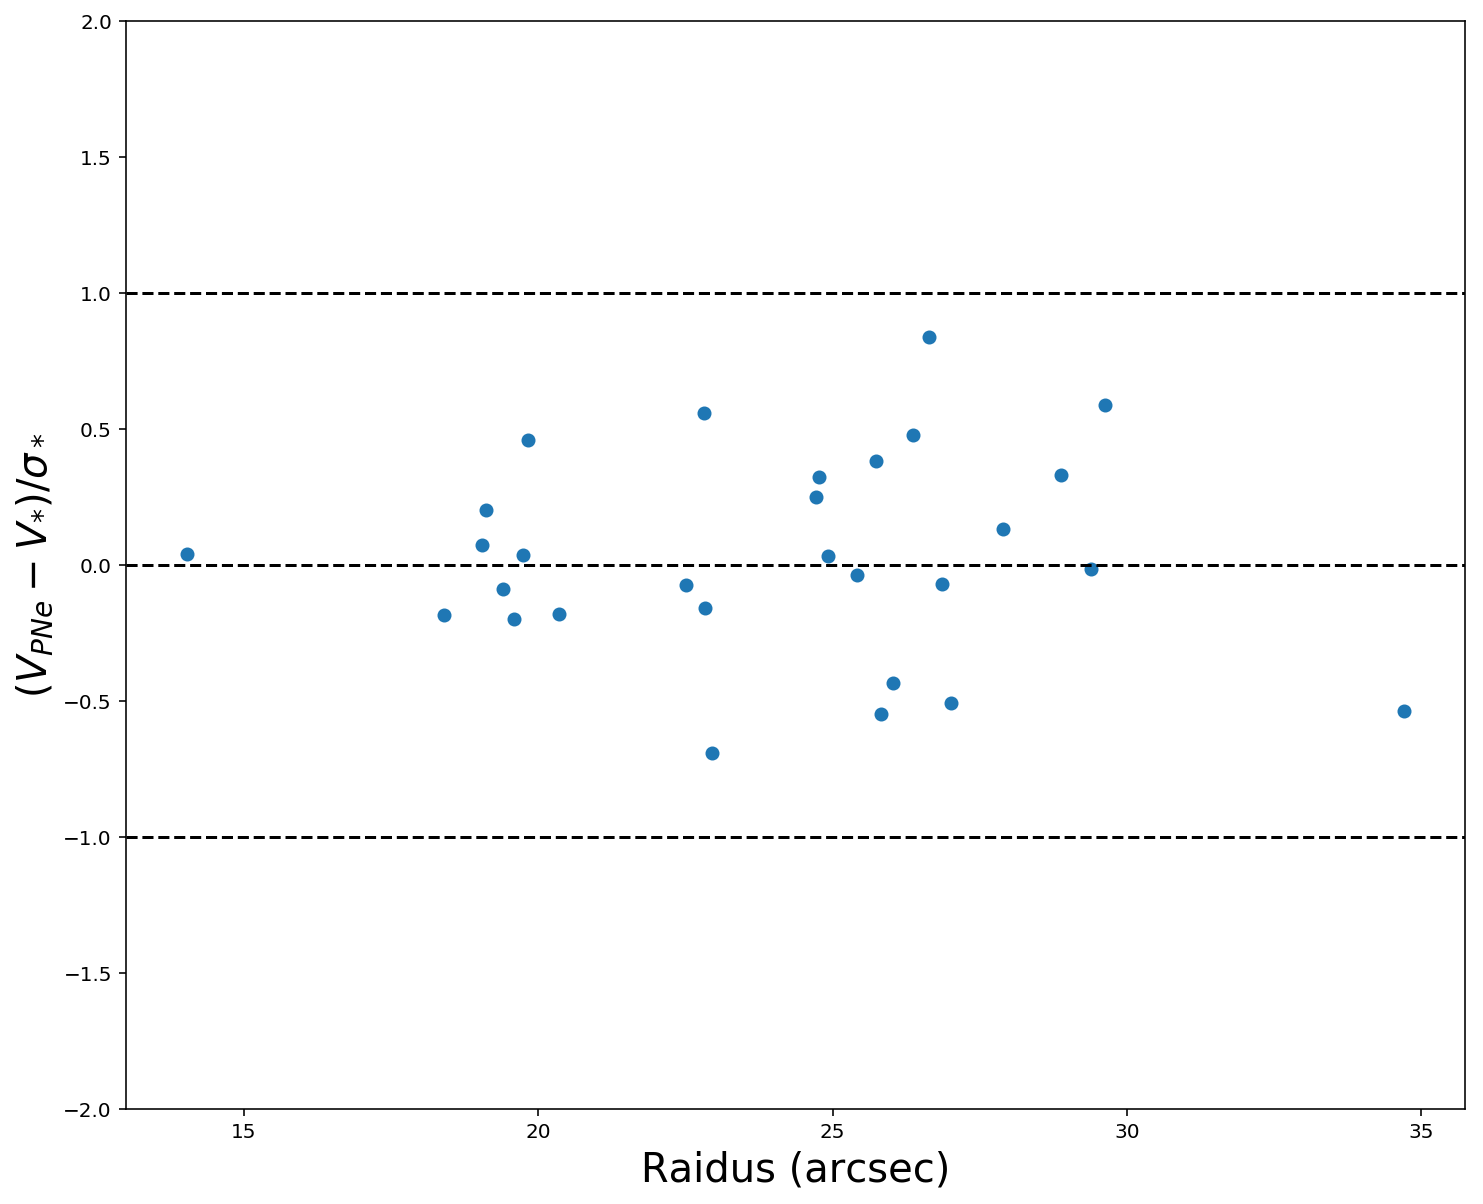

In [13]:
# radial analysis
arcsec_per_px = 0.189 # pc

radius = np.sqrt((x_PNe - 157)**2 + (y_PNe - 159)**2)
rad_in_arcsec = radius * arcsec_per_px

PNe_vel_ratio = (PNe_df["V (km/s)"] - stellar_vel)/ stellar_dis

plt.figure(figsize=(12,10))
plt.scatter(rad_in_arcsec, PNe_vel_ratio)
plt.xlabel("Raidus (arcsec)", fontsize=20)
plt.ylabel("$(V_{PNe} - V_{*})/ \sigma_*$", fontsize=20)
plt.axhline(y=1, c="k", ls="dashed")
plt.axhline(y=0, c="k", ls="dashed")
plt.axhline(y=-1, c="k", ls="dashed")
plt.ylim(-2,2)


## PSF multiple fit setup


# Single PSF fit runner

In [17]:
#sel_PNe = PNe_df.nlargest(2, "A/rN").index.values
sel_PNe = [0,4]

selected_PNe = PNe_spectra[sel_PNe]
selected_PNe_err = error_cube[sel_PNe] 
PSF_params = Parameters()

def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_{:03d}".format(n), value=amp, min=0.001)
    PSF_params.add("x_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_{:03d}".format(n), value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_{:03d}".format(n), value=mean, min=5000., max=5070.)
    PSF_params.add("gauss_bkg_{:03d}".format(n), value=0.001)
    PSF_params.add("gauss_grad_{:03d}".format(n), value=0.001)


for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5007.0)    
    
PSF_params.add('FWHM', value=4.0, min=0.01, max=12., vary=True)
PSF_params.add("beta", value=4.0, min=0.01, max=12., vary=True) 
PSF_params.add("Gauss_FWHM", value=0.00000, min=0.000001, max=3.0, vary=False) # LSF, instrumental resolution.

PSF_results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err, np.ones(len(sel_PNe))), nan_policy="propagate")

print("FWHM: ",PSF_results.params["FWHM"].value, "+/-", PSF_results.params["FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["FWHM"].stderr/PSF_results.params["FWHM"].value)*100) )
print("Beta: ",PSF_results.params["beta"].value, "+/-", PSF_results.params["beta"].stderr, "({:3.2f}%)".format((PSF_results.params["beta"].stderr/PSF_results.params["beta"].value)*100) )
print("Gauss FWHM: ", PSF_results.params["Gauss_FWHM"].value, "+/-", PSF_results.params["Gauss_FWHM"].stderr, "({:3.2f}%)".format((PSF_results.params["Gauss_FWHM"].stderr/PSF_results.params["Gauss_FWHM"].value)*100) )
print(report_fit(PSF_results))

FWHM:  6.89103536698857 +/- 0.3370018299950068 (4.89%)
Beta:  1.5132173556898627 +/- 0.31631426690916015 (20.90%)
Gauss FWHM:  1e-06 +/- 0 (0.00%)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 412
    # data points      = 91598
    # variables        = 14
    chi-square         = 90499.6018
    reduced chi-square = 0.98815952
    Akaike info crit   = -1077.03700
    Bayesian info crit = -945.084699
[[Variables]]
    moffat_amp_000:  132.074855 +/- 5.86937618 (4.44%) (init = 200)
    x_000:           6.31607353 +/- 0.10237943 (1.62%) (init = 6.5)
    y_000:           6.90897827 +/- 0.10635580 (1.54%) (init = 6.5)
    mean_000:        5003.61789 +/- 0.03519038 (0.00%) (init = 5007)
    gauss_bkg_000:   0.00976631 +/- 4.7802e-04 (4.89%) (init = 0.001)
    gauss_grad_000: -50.1245466 +/- 2.40228162 (4.79%) (init = 0.001)
    moffat_amp_001:  125.784575 +/- 5.99316519 (4.76%) (init = 200)
    x_001:           6.41703450 +/- 0.15592684 (2.43%) (init = 6.5)
    

## PSF Minimizer

In [ ]:
num_psf=10
fitted_FWHM = np.zeros(num_psf)
fitted_beta = np.zeros(num_psf)
A_rN_total = np.zeros(num_psf)
fitted_G_FWHM = np.zeros(num_psf)

#params = Parameters()
def model_params(p, n, amp, mean):
    PSF_params.add("moffat_amp_%d" %n, value=amp, min=0.001)
    PSF_params.add("x_%d" %n, value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("y_%d" %n, value=n_pixels/2., min=0.001, max=n_pixels)
    PSF_params.add("mean_%d" %n, value=mean, min=4990., max=5060.)
    PSF_params.add("gauss_bkg_%d" %n, value=0.001)
    PSF_params.add("gauss_grad_%d" %n, value=0.00001)
    
for j in np.arange(0, num_psf):
    sel_PNe = PNe_df.nlargest(j+1, "A/rN").index.values
    selected_PNe = PNe_spectra[sel_PNe]
    selected_PNe_err = error_cube[sel_PNe]
    PSF_params = Parameters()
    for i in np.arange(0,len(sel_PNe)):
        model_params(p=PSF_params, n=i, amp=200.0, mean=5035.0)
    PSF_params.add('FWHM', value=4.0, min=0.001, max=12., vary=True)
    PSF_params.add("beta", value=4.0, min=0.001, max=12., vary=True) 
    PSF_params.add("Gauss_FWHM", value=0.0, min=0.0001, max=3.0, vary=False)
    A_rN_total[j] = np.sqrt(np.sum(PNe_df.iloc[sel_PNe]["A/rN"]**2))
    results = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
    fitted_FWHM[j] = results.params["FWHM"].value
    fitted_beta[j] = results.params["beta"].value
    fitted_G_FWHM[j] = results.params["Gauss_FWHM"].value
    

In [ ]:
plt.figure(figsize=(14,8))
plt.scatter(A_rN_total, fitted_FWHM, label="FWHM", c="blue")
plt.scatter(A_rN_total, fitted_beta, label="beta", c="red")
plt.scatter(A_rN_total, fitted_G_FWHM, label="G_FWHM", c="k" )
plt.xlabel("A/rN")
plt.ylabel("FWHM and Beta")
plt.grid()

plt.axhline(np.median(fitted_FWHM[:]), label="FWHM median", ls="dashed", c="blue")
plt.axhline(np.median(fitted_beta[:]), label="Beta median", ls="dashed", c="red")
plt.axhline(np.median(fitted_G_FWHM[:]), label="G_FWHM median", ls="dashed", c="k")

plt.legend()
plt.savefig("Plots/M87/PSF_A_rN_FWHM_beta.png")

In [11]:
# Pull out the 1D flux data from 1D fits to do radial comparison
gauss_1D_A = np.load("exported_data/M87/gauss_A.npy")
A_rN_plot = np.load("exported_data/M87/A_rN.npy")

Flux_1D = gauss_1D_A * np.sqrt(2*np.pi) * 1.19
Flux_1D_cube = Flux_1D.reshape(y_data, x_data)
A_rN_plot_shape = A_rN_plot.reshape(y_data, x_data)

PNe_1D_flux_data = np.array([PNextractor(x, y, n_pixels, Flux_1D_cube) for x,y in zip(x_PNe,y_PNe)])
PNe_1D_A_rN_data = np.array([PNextractor(x, y, n_pixels, A_rN_plot_shape) for x,y in zip(x_PNe,y_PNe)])

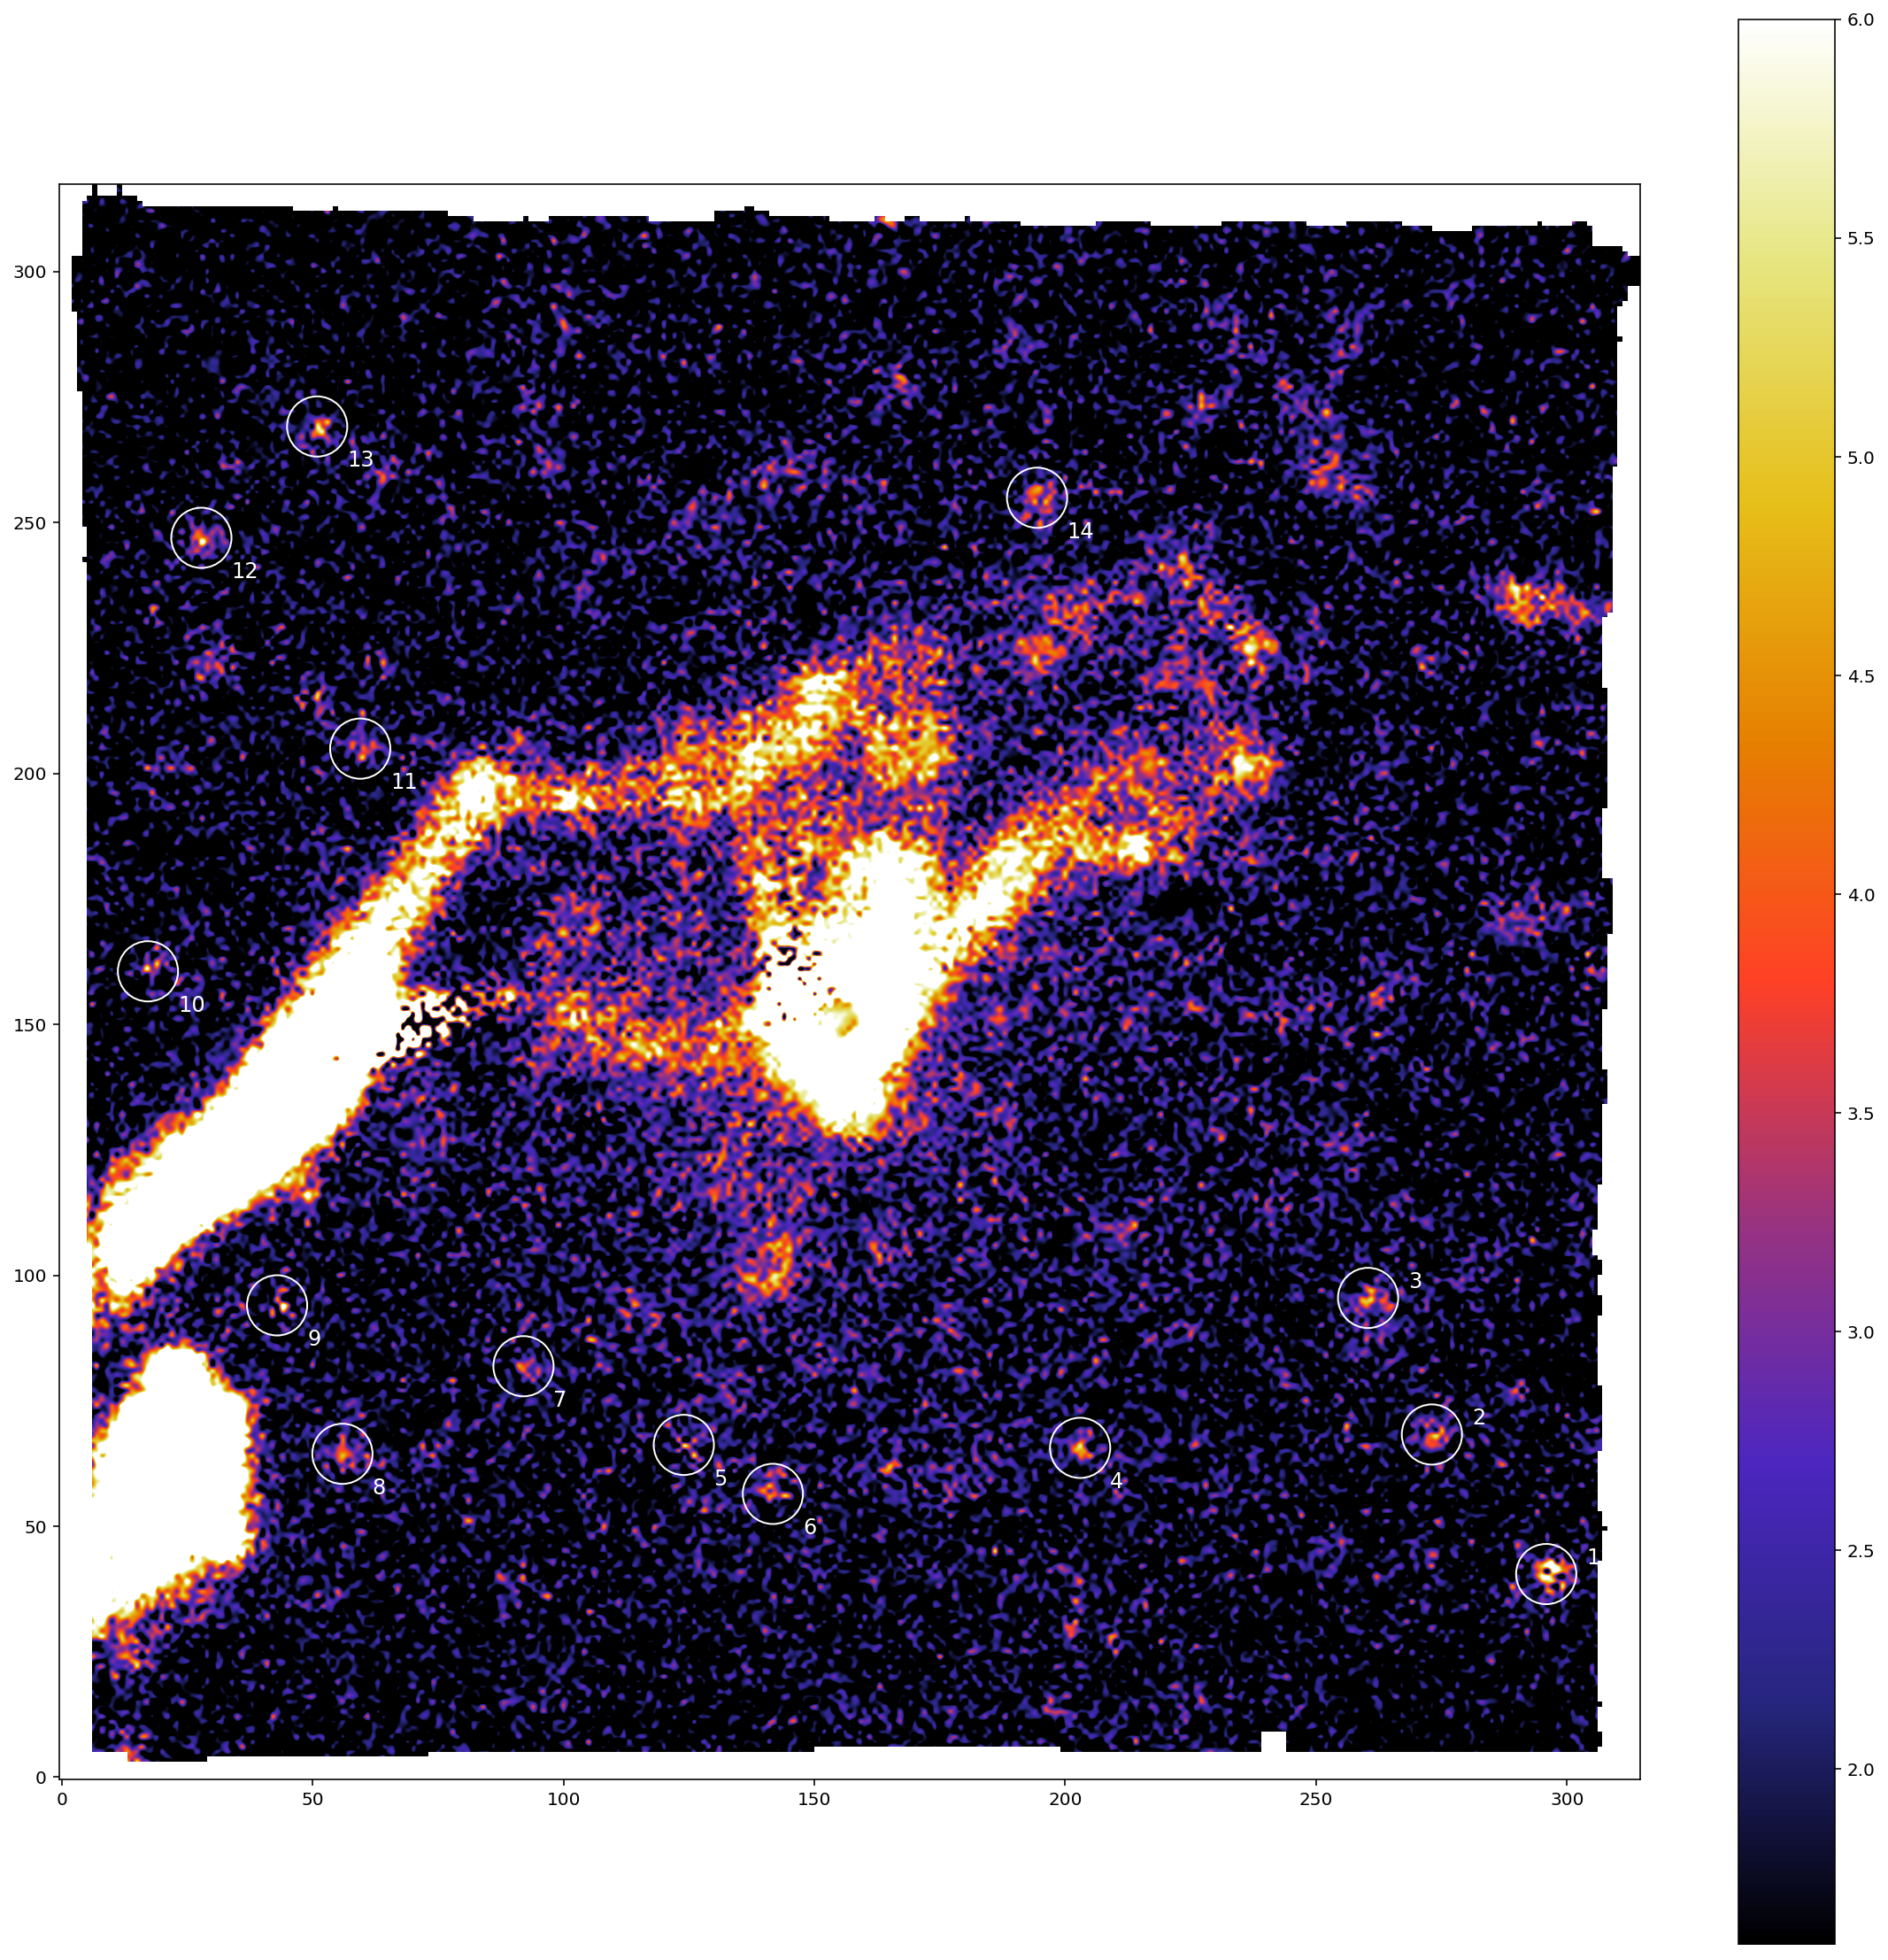

In [12]:
plt.figure(2,figsize=(20,20))
plt.imshow(A_rN_plot_shape, interpolation="spline16",origin="lower", cmap="CMRmap", vmin=1.6, vmax=6)
cb = plt.colorbar()
for i, item in enumerate(x_y_list):
    ax = plt.gca()
    circ = plt.Circle((item[0],item[1]),6, color="white", fill=False)
    ax.add_artist(circ)
    if item[0]<240.:
        ax.annotate(i+1, (item[0]+6, item[1]-8), color="white", size=12)
    else:
        ax.annotate(i+1, (item[0]+8, item[1]+2), color="white", size=12)
    plt.draw()

## PSF MCMC routine

In [7]:
def lnprob(p, data, error):
    noise = p["f"]
    res = PSF_residuals(PSF_params, wavelength, x_fit, y_fit, data, error)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# add a noise parameter and run MCMC for each run from results_for_MCMC
run_mini = minimize(PSF_residuals, PSF_params, args=(wavelength, x_fit, y_fit, selected_PNe, selected_PNe_err), nan_policy="propagate")
print("Initial run complete")
#add noise parameter
run_mini.params.add('f', value=1, min=0.001, max=2)
print("added f")
mini_lnprob = Minimizer(lnprob, run_mini.params, fcn_args=(selected_PNe, selected_PNe_err))
print("Minimizer run")
# Run MCMC routine
print("All go for MCMC")
MCMC_results = mini_lnprob.emcee(nwalkers=100, burn=500, steps=3000, thin=5, is_weighted=True, params=run_mini.params)

print("FWHM: " , MCMC_results.params["FWHM"].value, MCMC_results.params["FWHM"].stderr)
print("Beta: " , MCMC_results.params["beta"].value, MCMC_results.params["beta"].stderr)

Initial run complete
added f
Minimizer run
All go for MCMC


C:\Users\tspri\Anaconda3\lib\site-packages\emcee-2.2.1-py3.5.egg\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
C:\Users\tspri\Anaconda3\lib\site-packages\emcee-2.2.1-py3.5.egg\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater


Gamma:  6.88827603298 4.26221737712
Alpha:  1.0885229982 0.527905820424


## MCMC Fitting

FloatProgress(value=0.0, description='Fitting progress', max=26.0)

CPU times: user 10min 32s, sys: 3min 30s, total: 14min 3s
Wall time: 3h 37min 2s


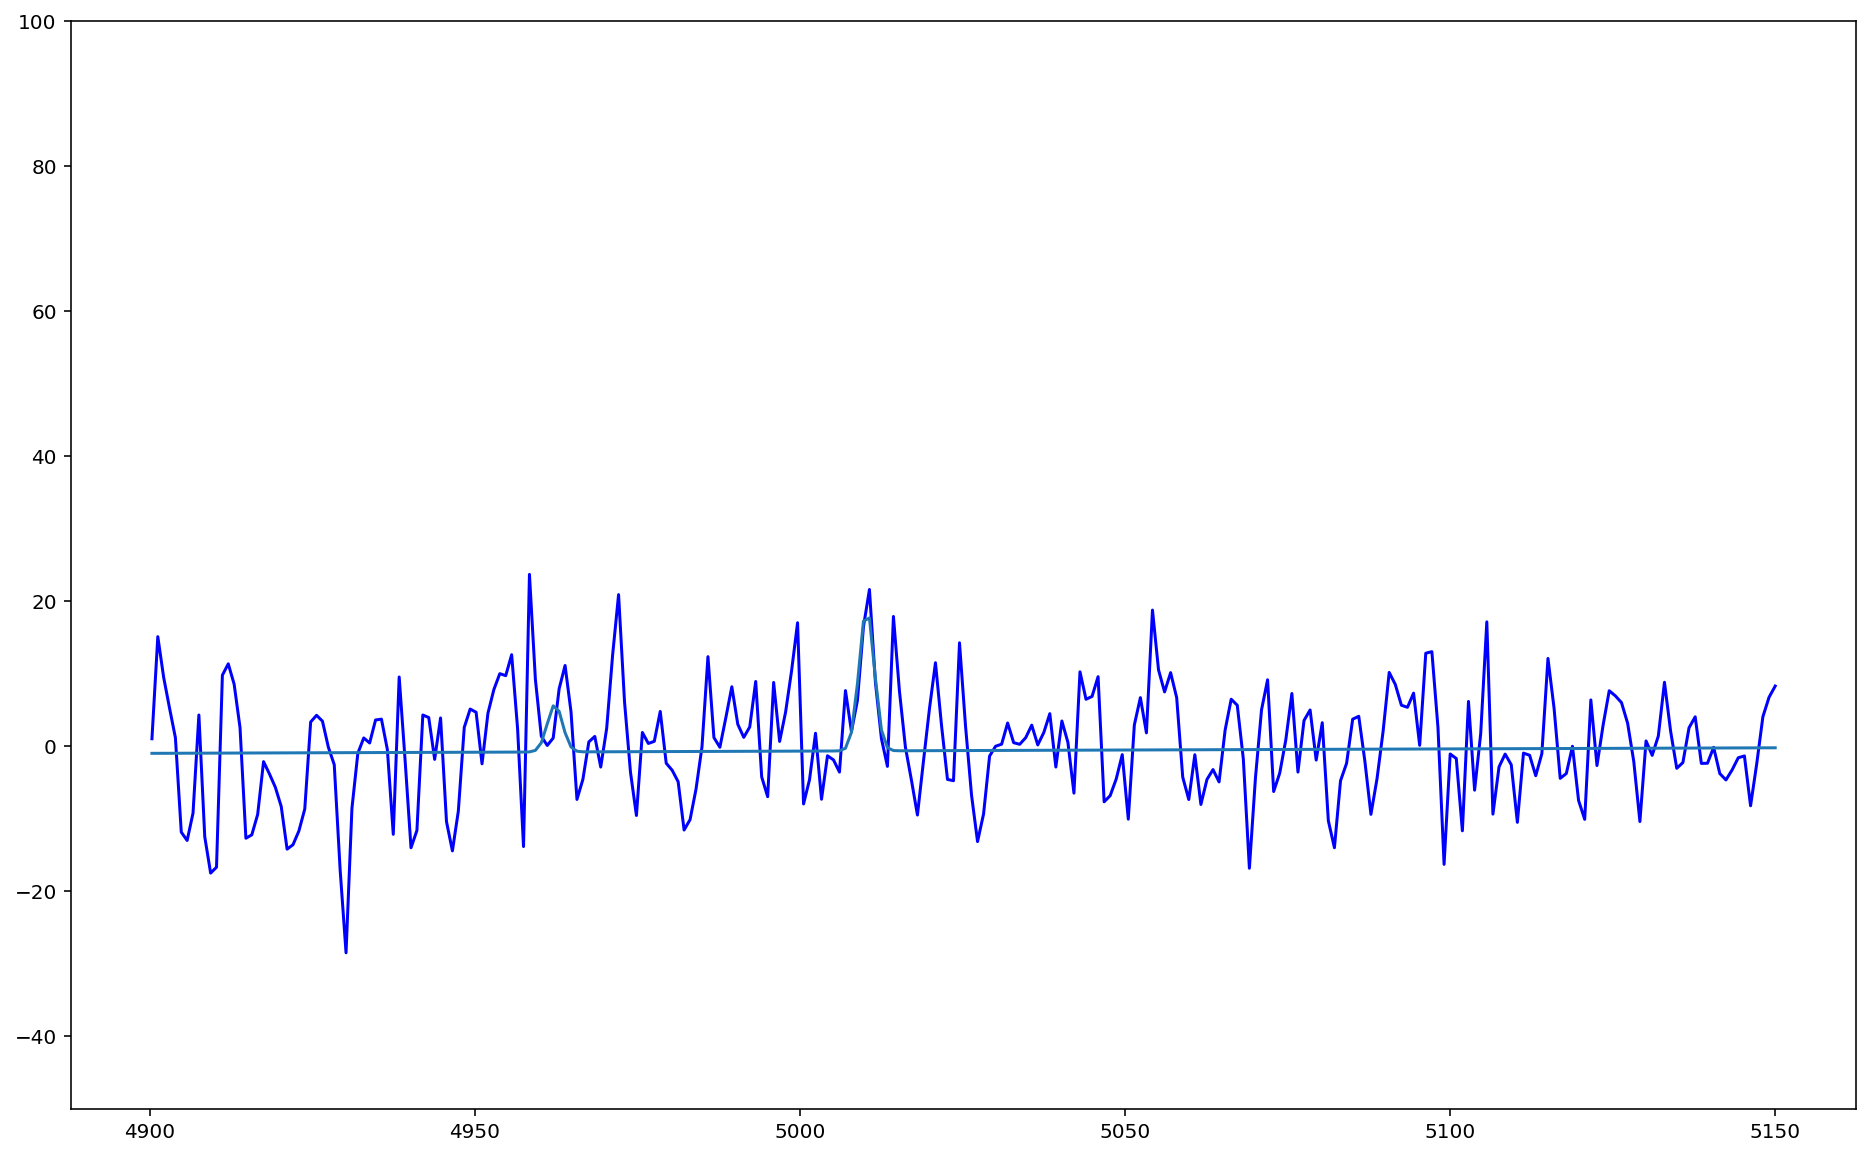

In [68]:
%%time
# Using MCMC from LMFit, with emcee to fit sources

def lnprob(params, data, error, num):
    noise = params["f"]
    res = MUSE_3D_residual(params, wavelength, x_fit, y_fit, data, error, num, useful_stuff, wavelength)
    return -0.5 * np.sum((res / noise)**2 + np.log(2 * np.pi * noise**2))

# Use minimization results from above

MCMC_moff_amp = np.zeros(len(x_PNe))
MCMC_gamma = np.zeros(len(x_PNe))
MCMC_alpha = np.zeros(len(x_PNe))
MCMC_params = np.zeros((len(x_PNe),10))
useful_stuff = []

# add a noise parameter and run MCMC for each run from results_for_MCMC
for PNe_num in np.arange(0, len(x_PNe)):
    run_mini = source_minimizer(PNe_num)
    mini_result = run_mini
    #add noise parameter
    mini_result.params.add('f', value=1, min=0.001, max=2)
    mini_lnprob = Minimizer(lnprob, mini_result.params, fcn_args=(PNe_spectra[PNe_num], error_cube[PNe_num], PNe_num))
    # Run MCMC routine
    MCMC_results = mini_lnprob.emcee(nwalkers=50, burn=400, steps=1000, thin=10, workers=3, params=mini_result.params)
    # store results
    MCMC_moff_amp[PNe_num] = MCMC_results.params["moffat_amp"]
    MCMC_gamma = MCMC_results.params["gamma"]
    MCMC_alpha = MCMC_results.params["alpha"]
    MCMC_params = MCMC_results.params
    PNe_df.loc[PNe_num, "V (km/s)"] = (c * (MCMC_results.params["mean"].value - 5006.9) / 5006.9) / 1000


    